/opt/anaconda3/envs/ML/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



Processing Crude Oil Brent Price


/var/folders/rd/tqc_535n6bb2mkqrf4_7nf6w0000gn/T/ipykernel_66537/2507245840.py:123: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  prophet_df['3mo_rolling_mean'] = prophet_df['y'].rolling(3).mean().fillna(method='bfill')
/var/folders/rd/tqc_535n6bb2mkqrf4_7nf6w0000gn/T/ipykernel_66537/2507245840.py:124: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  prophet_df['12mo_rolling_mean'] = prophet_df['y'].rolling(12).mean().fillna(method='bfill')
/var/folders/rd/tqc_535n6bb2mkqrf4_7nf6w0000gn/T/ipykernel_66537/2507245840.py:129: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  prophet_df[f'{feature}_lag3'] = train_df[feature].shift(3).fillna(method='bfill').values
/var/folders/rd/tqc_535n6bb2mkqrf4_7nf6w0000gn/T/ipykernel_66537/2507245


=== Crude Oil Brent Price Performance ===
Median MAPE: 1.61%

Monthly MAPE Breakdown:
month
1     100.087435
2      91.332778
3     206.288245
4     126.379571
5     204.776910
6     137.579261
7     151.681986
8     128.216859
9     154.027504
10    189.205536
11    196.449609
12    199.711713
dtype: float64


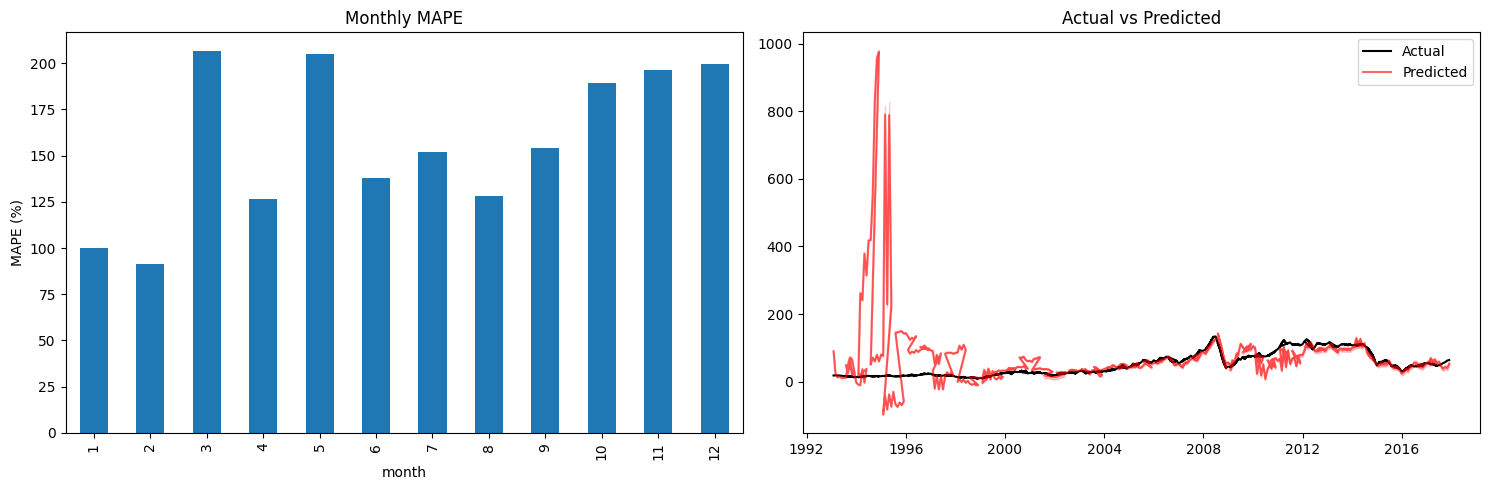

/opt/anaconda3/envs/ML/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


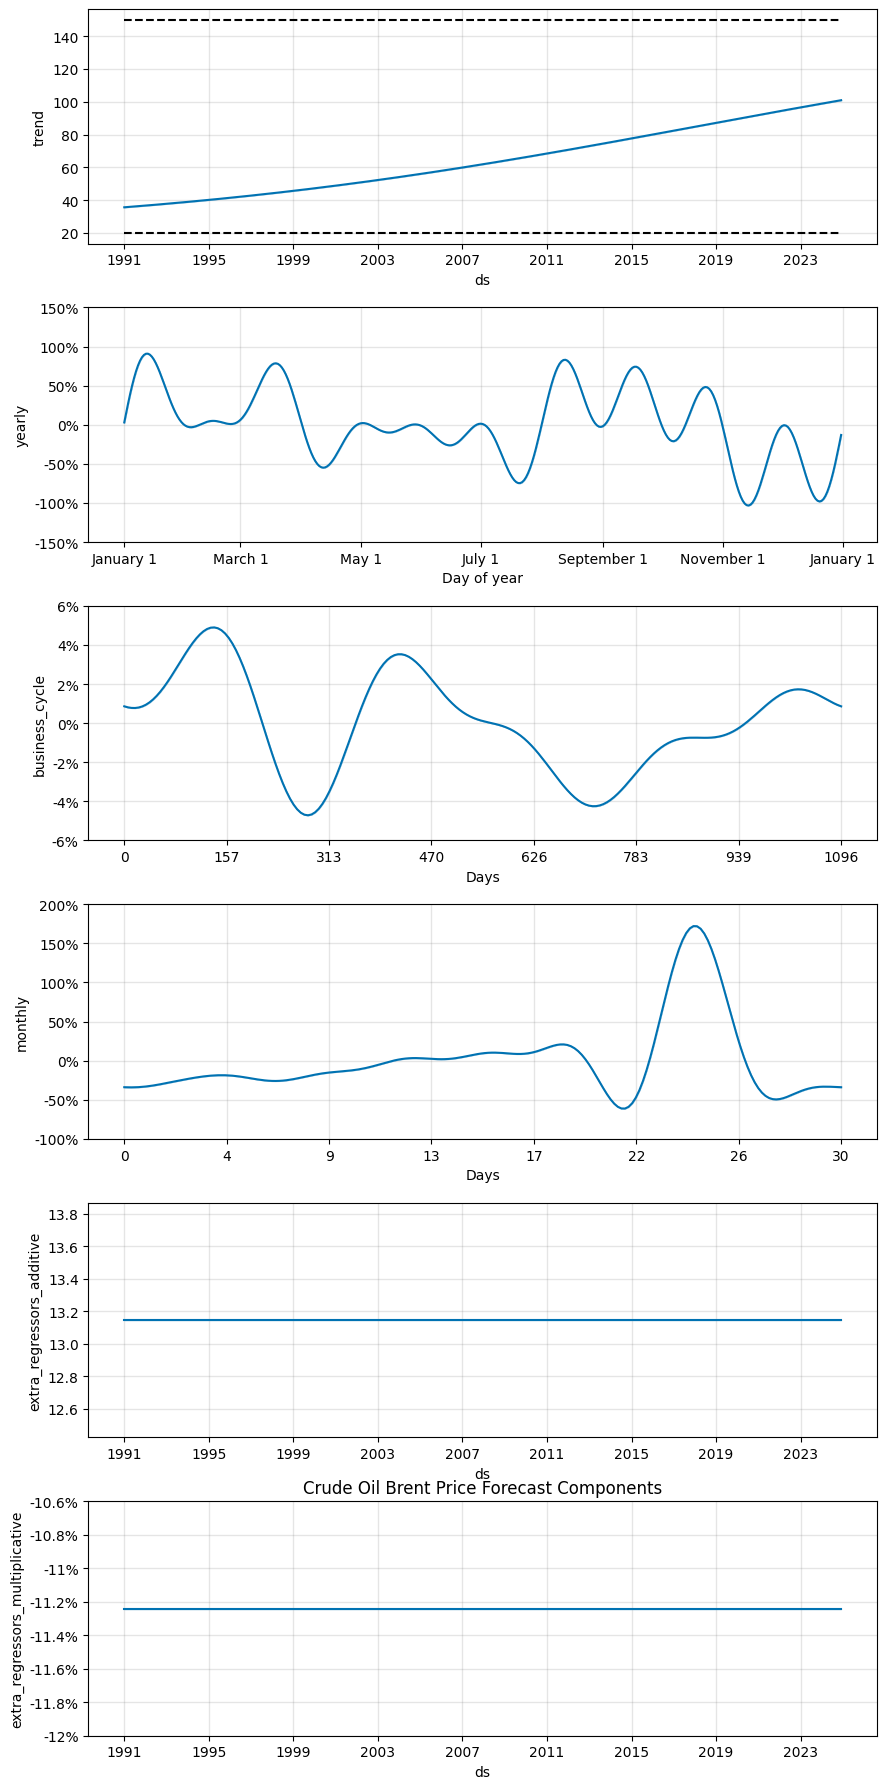

/var/folders/rd/tqc_535n6bb2mkqrf4_7nf6w0000gn/T/ipykernel_66537/2507245840.py:123: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  prophet_df['3mo_rolling_mean'] = prophet_df['y'].rolling(3).mean().fillna(method='bfill')
/var/folders/rd/tqc_535n6bb2mkqrf4_7nf6w0000gn/T/ipykernel_66537/2507245840.py:124: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  prophet_df['12mo_rolling_mean'] = prophet_df['y'].rolling(12).mean().fillna(method='bfill')
/var/folders/rd/tqc_535n6bb2mkqrf4_7nf6w0000gn/T/ipykernel_66537/2507245840.py:129: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  prophet_df[f'{feature}_lag3'] = train_df[feature].shift(3).fillna(method='bfill').values
/var/folders/rd/tqc_535n6bb2mkqrf4_7nf6w0000gn/T/ipykernel_66537/2507245


Processing Cocoa Price


  0%|          | 0/49 [00:00<?, ?it/s]02:07:04 - cmdstanpy - INFO - Chain [1] start processing
02:07:04 - cmdstanpy - INFO - Chain [1] done processing
  2%|▏         | 1/49 [00:00<00:19,  2.49it/s]02:07:04 - cmdstanpy - INFO - Chain [1] start processing
02:07:05 - cmdstanpy - INFO - Chain [1] done processing
  4%|▍         | 2/49 [00:01<00:27,  1.68it/s]02:07:05 - cmdstanpy - INFO - Chain [1] start processing
02:07:09 - cmdstanpy - INFO - Chain [1] done processing
  6%|▌         | 3/49 [00:05<01:40,  2.19s/it]02:07:09 - cmdstanpy - INFO - Chain [1] start processing
02:07:10 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 4/49 [00:06<01:17,  1.73s/it]02:07:10 - cmdstanpy - INFO - Chain [1] start processing
02:07:11 - cmdstanpy - INFO - Chain [1] done processing
 10%|█         | 5/49 [00:07<01:12,  1.65s/it]02:07:11 - cmdstanpy - INFO - Chain [1] start processing
02:07:18 - cmdstanpy - INFO - Chain [1] done processing
 12%|█▏        | 6/49 [00:14<02:23,  3.34s/it]02:07:18


=== Cocoa Price Performance ===
Median MAPE: 0.43%

Monthly MAPE Breakdown:
month
1     31.846954
2     40.498374
3     44.291894
4     44.989529
5     44.827787
6     41.742544
7     51.490954
8     43.235344
9     40.722776
10    41.329739
11    42.662601
12    43.209338
dtype: float64


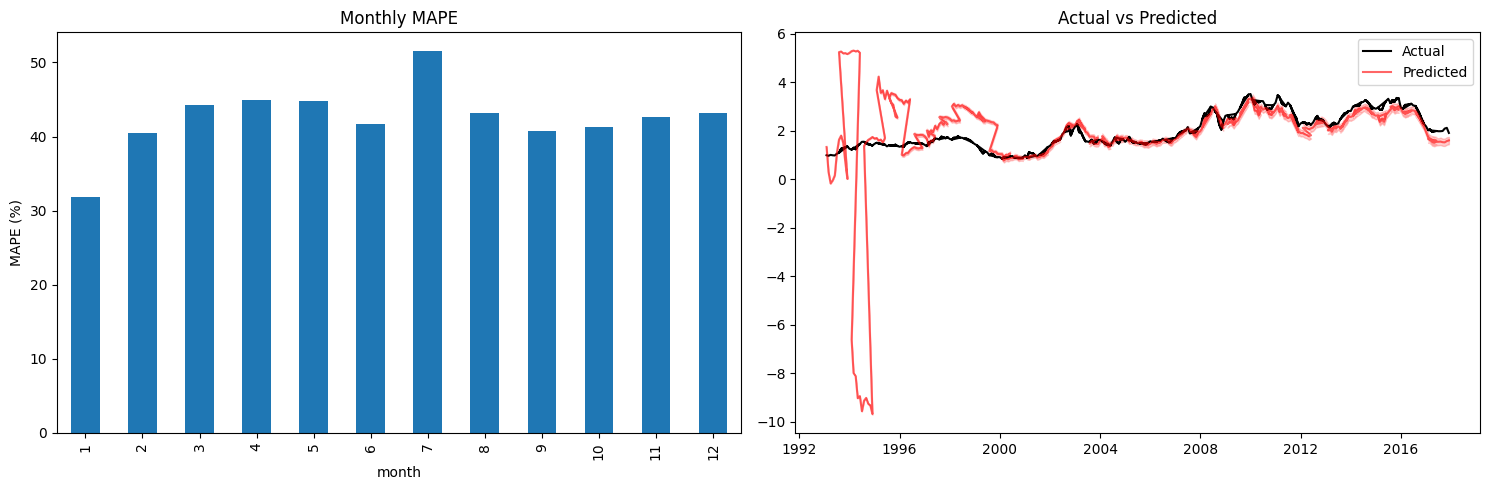

/opt/anaconda3/envs/ML/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


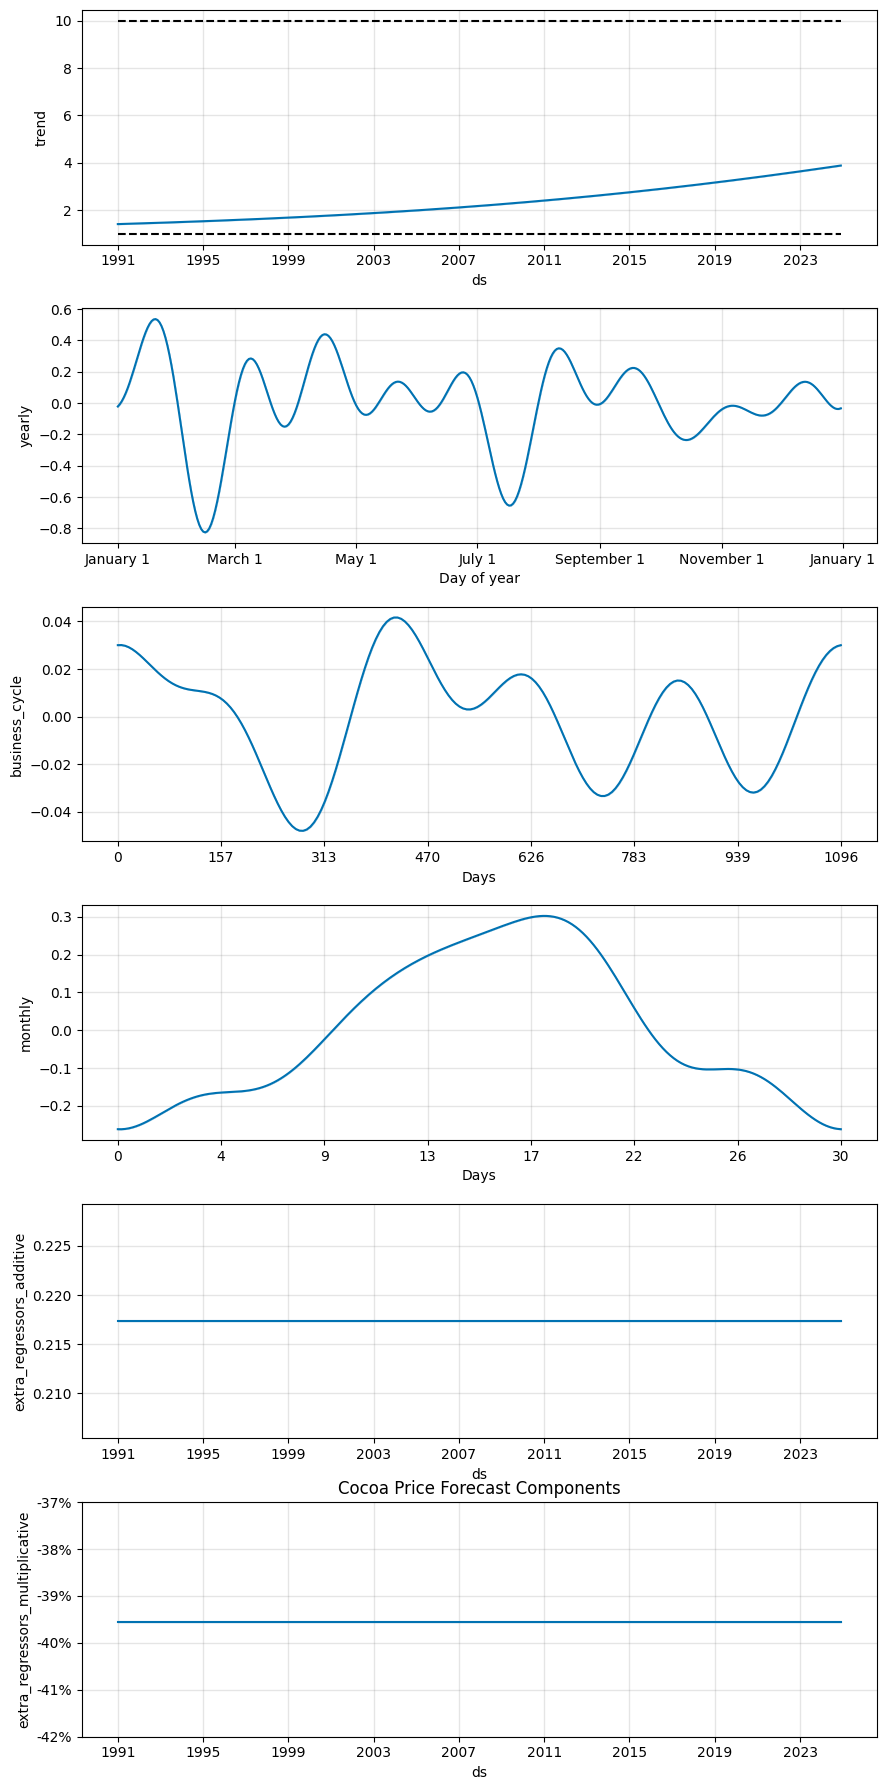

/var/folders/rd/tqc_535n6bb2mkqrf4_7nf6w0000gn/T/ipykernel_66537/2507245840.py:123: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  prophet_df['3mo_rolling_mean'] = prophet_df['y'].rolling(3).mean().fillna(method='bfill')
/var/folders/rd/tqc_535n6bb2mkqrf4_7nf6w0000gn/T/ipykernel_66537/2507245840.py:124: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  prophet_df['12mo_rolling_mean'] = prophet_df['y'].rolling(12).mean().fillna(method='bfill')
/var/folders/rd/tqc_535n6bb2mkqrf4_7nf6w0000gn/T/ipykernel_66537/2507245840.py:129: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  prophet_df[f'{feature}_lag3'] = train_df[feature].shift(3).fillna(method='bfill').values
/var/folders/rd/tqc_535n6bb2mkqrf4_7nf6w0000gn/T/ipykernel_66537/2507245


Processing Gold Price


  0%|          | 0/49 [00:00<?, ?it/s]02:07:26 - cmdstanpy - INFO - Chain [1] start processing
02:07:27 - cmdstanpy - INFO - Chain [1] done processing
  2%|▏         | 1/49 [00:00<00:16,  2.95it/s]02:07:27 - cmdstanpy - INFO - Chain [1] start processing
02:07:27 - cmdstanpy - INFO - Chain [1] done processing
  4%|▍         | 2/49 [00:00<00:15,  2.96it/s]02:07:27 - cmdstanpy - INFO - Chain [1] start processing
02:07:48 - cmdstanpy - INFO - Chain [1] done processing
  6%|▌         | 3/49 [00:21<07:24,  9.67s/it]02:07:48 - cmdstanpy - INFO - Chain [1] start processing
02:07:56 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 4/49 [00:29<06:42,  8.94s/it]02:07:56 - cmdstanpy - INFO - Chain [1] start processing
02:07:57 - cmdstanpy - INFO - Chain [1] done processing
 10%|█         | 5/49 [00:30<04:27,  6.09s/it]02:07:57 - cmdstanpy - INFO - Chain [1] start processing
02:08:03 - cmdstanpy - INFO - Chain [1] done processing
 12%|█▏        | 6/49 [00:36<04:26,  6.19s/it]02:08:03


=== Gold Price Performance ===
Median MAPE: 0.47%

Monthly MAPE Breakdown:
month
1      23.499968
2      32.430872
3      77.998805
4      41.673241
5      86.141198
6      48.003189
7     101.546409
8      34.021249
9      30.308706
10     25.448019
11     30.551350
12     29.844987
dtype: float64


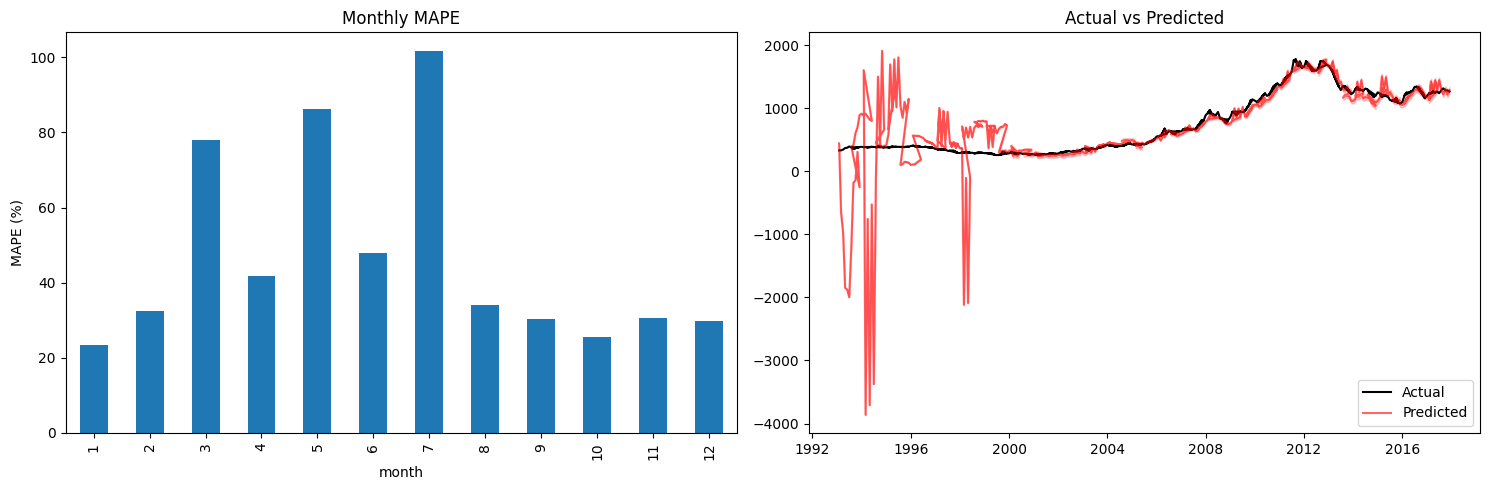

/opt/anaconda3/envs/ML/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


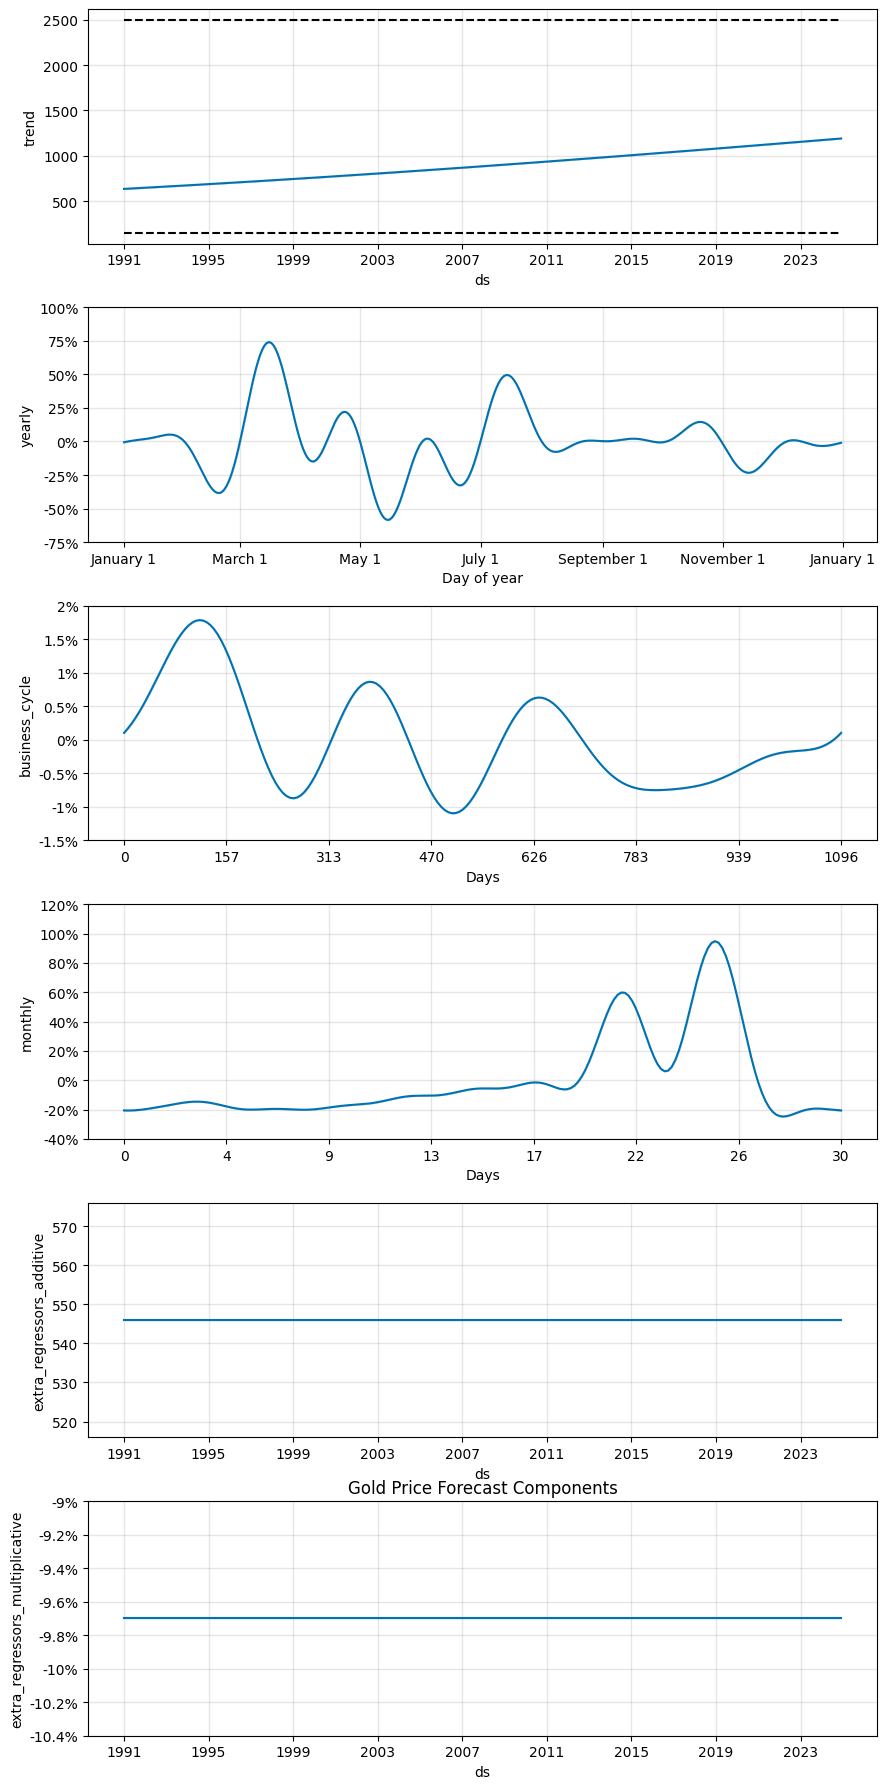



=== FINAL TEST SET EVALUATION ===

Crude Oil Brent Price Test Evaluation:
- Time Period: 2018-04-01 to 2024-12-01
- Test Points: 81
- Valid Points: 81
- MAPE: 94.54%
- MAE: 59.39
- RMSE: 64.65


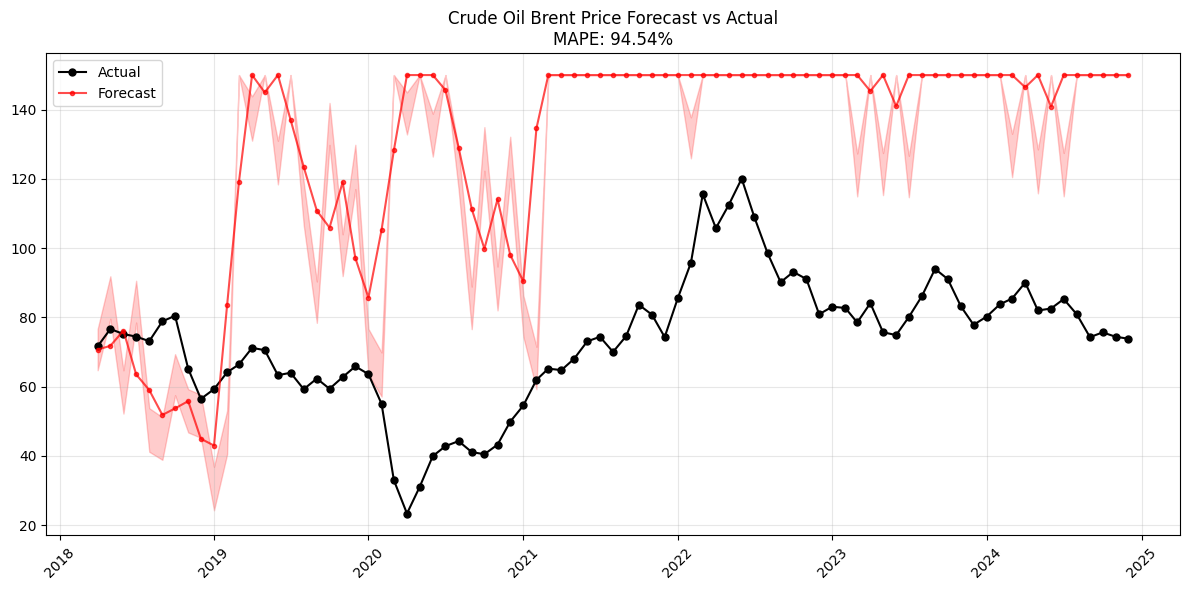


Cocoa Price Test Evaluation:
- Time Period: 2018-04-01 to 2024-12-01
- Test Points: 81
- Valid Points: 81
- MAPE: 20.63%
- MAE: 1.03
- RMSE: 2.01


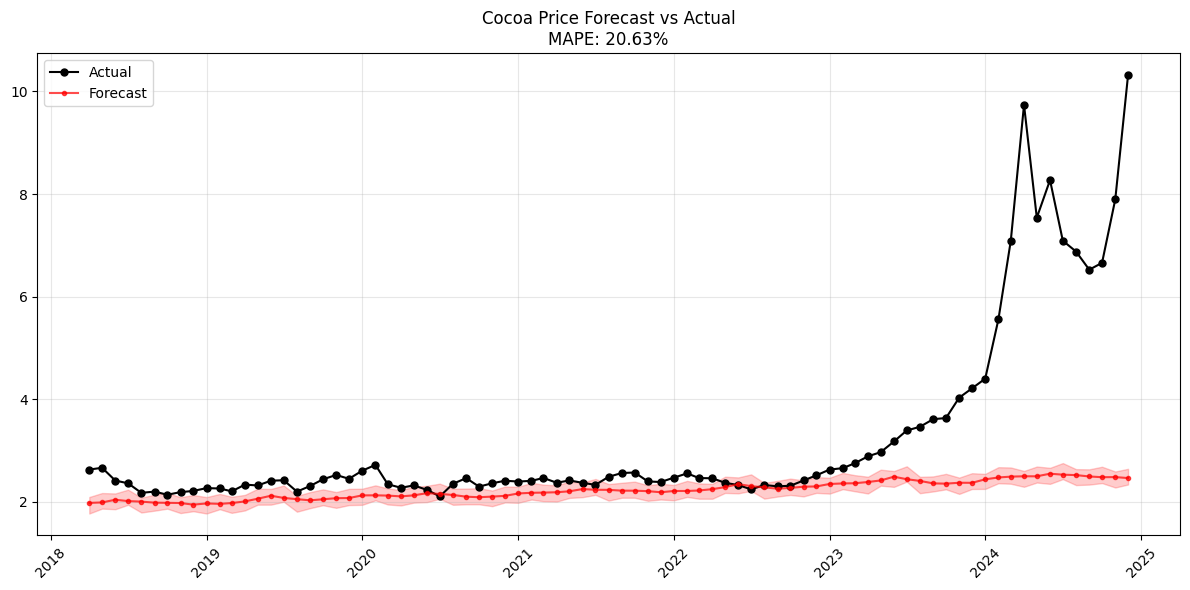


Gold Price Test Evaluation:
- Time Period: 2018-04-01 to 2024-12-01
- Test Points: 81
- Valid Points: 81
- MAPE: 25.62%
- MAE: 442.69
- RMSE: 519.99


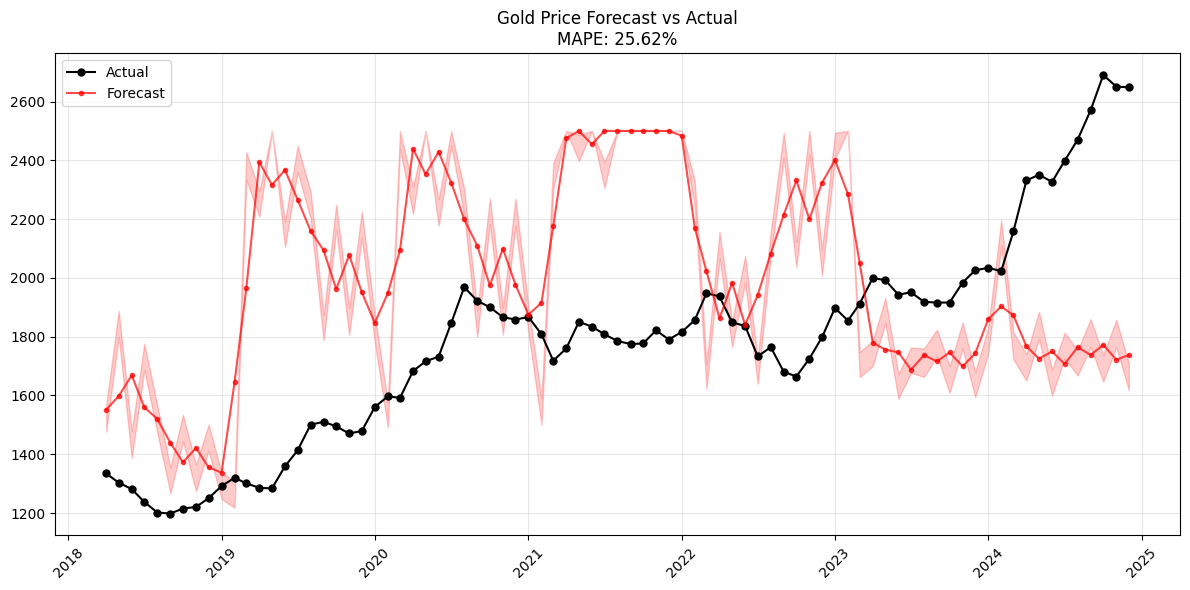

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from itertools import product

# 1. Data Loading and Preparation
df = pd.read_csv('merged_macro_commodity.csv', parse_dates=['date'])
df.set_index('date', inplace=True)
df_reset = df.reset_index()

# Commodity and feature setup
commodity_cols = ['Crude Oil Brent Price', 'Cocoa Price', 'Gold Price']
feature_cols = ['Revenue, excluding grants (% of GDP)', 
                'GDP (constant 2015 US$)', 
                'Employment to population ratio (15+, total %)']

# Split data (last 20% for testing)
test_size = int(0.2 * len(df_reset))
train_df = df_reset.iloc[:-test_size]
test_df = df_reset.iloc[-test_size:]

# Commodity-specific configurations
commodity_params = {
    'Crude Oil Brent Price': {
        'changepoint_prior_scale': 0.1,
        'seasonality_prior_scale': 15,
        'seasonality_mode': 'multiplicative',
        'fourier_order': 8,
        'bounds': {'floor': 20, 'cap': 150}
    },
    'Cocoa Price': {
        'changepoint_prior_scale': 0.05,
        'seasonality_prior_scale': 20,
        'seasonality_mode': 'additive',
        'fourier_order': 5,
        'bounds': {'floor': 1, 'cap': 10}
    },
    'Gold Price': {
        'changepoint_prior_scale': 0.01,
        'seasonality_prior_scale': 10,
        'seasonality_mode': 'multiplicative',
        'fourier_order': 10,
        'bounds': {'floor': 150, 'cap': 2500}
    }
}

# Helper functions
def calculate_mape(y_true, y_pred):
    mask = (y_true != 0)
    return 100 * np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask]))

def monthly_cross_validation(model, train_months=24, horizon_months=12, period_months=6):
    history_df = model.history.copy()
    first_date = history_df['ds'].min()
    last_date = history_df['ds'].max()
    
    cutoff = first_date + pd.DateOffset(months=train_months)
    cutoffs = []
    while cutoff + pd.DateOffset(months=horizon_months) <= last_date:
        cutoffs.append(cutoff)
        cutoff = cutoff + pd.DateOffset(months=period_months)
    
    return cross_validation(model, cutoffs=cutoffs, horizon=f'{horizon_months * 30} days')

def enhanced_performance_metrics(df_cv: pd.DataFrame, commodity_name):
    df_cv['month'] = df_cv['ds'].dt.month
    df_cv['year'] = df_cv['ds'].dt.year
    
    # Monthly breakdown
    monthly_mape = df_cv.groupby('month').apply(
        lambda x: calculate_mape(x['y'], x['yhat'])
    )
    
    # Overall metrics
    overall = performance_metrics(df_cv)
    mean_mape = np.mean(overall['mape'])
    
    print(f"\n=== {commodity_name} Performance ===")
    print(f"Median MAPE: {mean_mape:.2f}%")
    print("\nMonthly MAPE Breakdown:")
    print(monthly_mape)
    
    # Plotting
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    monthly_mape.plot(kind='bar', ax=ax[0], title='Monthly MAPE')
    ax[0].set_ylabel('MAPE (%)')
    
    # Actual vs Predicted
    ax[1].plot(df_cv['ds'], df_cv['y'], 'k-', label='Actual')
    ax[1].plot(df_cv['ds'], df_cv['yhat'], 'r-', alpha=0.6, label='Predicted')
    ax[1].fill_between(df_cv['ds'], df_cv['yhat_lower'], df_cv['yhat_upper'], color='r', alpha=0.2)
    ax[1].set_title('Actual vs Predicted')
    ax[1].legend()
    plt.tight_layout()
    plt.show()
    
    return overall

# Main forecasting pipeline
results = {}
for commodity in commodity_cols:
    print(f"\n{'='*50}")
    print(f"Processing {commodity}")
    print(f"{'='*50}")
    
    params = commodity_params[commodity]
    bounds = params['bounds']
    
    # Prepare dataframe
    prophet_df = train_df[['date', commodity]].rename(columns={'date': 'ds', commodity: 'y'})
    
    # 1. Outlier removal
    Q1 = prophet_df['y'].quantile(0.25)
    Q3 = prophet_df['y'].quantile(0.75)
    IQR = Q3 - Q1
    prophet_df = prophet_df[(prophet_df['y'] >= (Q1 - 1.5*IQR)) & (prophet_df['y'] <= (Q3 + 1.5*IQR))]
    
    # 2. Add rolling features
    prophet_df['3mo_rolling_mean'] = prophet_df['y'].rolling(3).mean().fillna(method='bfill')
    prophet_df['12mo_rolling_mean'] = prophet_df['y'].rolling(12).mean().fillna(method='bfill')
    
    # 3. Add regressors
    for feature in feature_cols:
        prophet_df[feature] = train_df[feature].values
        prophet_df[f'{feature}_lag3'] = train_df[feature].shift(3).fillna(method='bfill').values
    
    # 4. Scale features
    for feature in feature_cols + ['3mo_rolling_mean', '12mo_rolling_mean']:
        if 'GDP' in feature:
            scaler = RobustScaler()
        else:
            scaler = StandardScaler()
        prophet_df[feature] = scaler.fit_transform(prophet_df[feature].values.reshape(-1, 1))
    
    # 5. Set bounds
    prophet_df['floor'] = bounds['floor']
    prophet_df['cap'] = bounds['cap']
    
    # Initialize and configure model
    model = Prophet(
        yearly_seasonality=True,
        weekly_seasonality=False,
        daily_seasonality=False,
        interval_width=0.95,
        growth='logistic',
        changepoint_prior_scale=params['changepoint_prior_scale'],
        seasonality_prior_scale=params['seasonality_prior_scale'],
        seasonality_mode=params['seasonality_mode']
    )
    
    # Add custom seasonalities
    model.add_seasonality(
        name='monthly',
        period=30.5,
        fourier_order=params['fourier_order']
    )
    model.add_seasonality(
        name='business_cycle',
        period=365.25*3,
        fourier_order=5
    )
    
    # Add regressors
    for feature in feature_cols + ['3mo_rolling_mean', '12mo_rolling_mean']:
        mode = 'multiplicative' if ('GDP' in feature or 'Revenue' in feature) else 'additive'
        model.add_regressor(feature, mode=mode, standardize=False)
    
    # Fit model
    model.fit(prophet_df)
    
    # Cross-validation
    df_cv = monthly_cross_validation(model)
    cv_results = enhanced_performance_metrics(df_cv, commodity)
    
    # Future forecast
    future = model.make_future_dataframe(periods=test_size, freq='M')
    for feature in feature_cols + ['3mo_rolling_mean', '12mo_rolling_mean']:
        future[feature] = prophet_df[feature].iloc[-1]
    future['floor'] = bounds['floor']
    future['cap'] = bounds['cap']
    
    forecast = model.predict(future)
    
    # Post-processing
    forecast['yhat'] = forecast['yhat'].rolling(3, center=True, min_periods=1).mean()
    for col in ['yhat', 'yhat_lower', 'yhat_upper']:
        forecast[col] = forecast[col].clip(lower=bounds['floor'], upper=bounds['cap'])
    
    # Plot components
    fig = model.plot_components(forecast)
    plt.title(f'{commodity} Forecast Components')
    plt.show()
    
    # Store results
    results[commodity] = {
        'model': model,
        'forecast': forecast,
        'cv_metrics': cv_results
    }

# Final evaluation on test set
# Replace your test evaluation section with this:

print("\n\n=== FINAL TEST SET EVALUATION ===")
for commodity in commodity_cols:
    model = results[commodity]['model']
    forecast = results[commodity]['forecast']
    
    # Ensure proper datetime format
    test_actual = test_df[['date', commodity]].copy()
    test_actual = test_actual.rename(columns={'date': 'ds', commodity: 'y'})
    test_actual['ds'] = pd.to_datetime(test_actual['ds'])
    
    # Convert forecast dates to match test date precision
    forecast = forecast.copy()
    forecast['ds'] = pd.to_datetime(forecast['ds'])
    
    # Find overlapping dates (with tolerance for monthly data)
    merged = pd.merge_asof(
        test_actual.sort_values('ds'),
        forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].sort_values('ds'),
        on='ds',
        direction='nearest',
        tolerance=pd.Timedelta('15d')  # Allow 15-day window for monthly alignment
    )
    
    # Calculate metrics only if we have matches
    if len(merged) > 0:
        valid_points = (merged['y'] != 0) & (~merged['y'].isna()) & (~merged['yhat'].isna())
        n_valid = sum(valid_points)
        
        if n_valid > 0:
            # Calculate all metrics
            mape = 100 * np.mean(np.abs(
                (merged.loc[valid_points, 'y'] - merged.loc[valid_points, 'yhat']) / merged.loc[valid_points, 'y']
            ))
            mae = mean_absolute_error(merged.loc[valid_points, 'y'], merged.loc[valid_points, 'yhat'])
            rmse = np.sqrt(mean_squared_error(merged.loc[valid_points, 'y'], merged.loc[valid_points, 'yhat']))
            
            print(f"\n{commodity} Test Evaluation:")
            print(f"- Time Period: {merged['ds'].min().date()} to {merged['ds'].max().date()}")
            print(f"- Test Points: {len(merged)}")
            print(f"- Valid Points: {n_valid}")
            print(f"- MAPE: {mape:.2f}%")
            print(f"- MAE: {mae:.2f}")
            print(f"- RMSE: {rmse:.2f}")
            
            # Plotting
            plt.figure(figsize=(12, 6))
            plt.plot(merged['ds'], merged['y'], 'ko-', label='Actual', markersize=5)
            plt.plot(merged['ds'], merged['yhat'], 'r.-', label='Forecast', alpha=0.7)
            plt.fill_between(merged['ds'], merged['yhat_lower'], merged['yhat_upper'], color='r', alpha=0.2)
            plt.title(f'{commodity} Forecast vs Actual\nMAPE: {mape:.2f}%')
            plt.legend()
            plt.grid(True, alpha=0.3)
            plt.xticks(rotation=45)
            plt.tight_layout()
            plt.show()
        else:
            print(f"\n{commodity} - No valid non-zero points for evaluation")
            print("First 5 test values:")
            print(test_actual.head())
    else:
        print(f"\n{commodity} - No date matches between forecast and test set")
        print("Forecast date range:", forecast['ds'].min(), "to", forecast['ds'].max())
        print("Test date range:", test_actual['ds'].min(), "to", test_actual['ds'].max())